In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load data
training_dataset_file = open("mnist_train_200.csv", 'r')

training_dataset_list = training_dataset_file.readlines()
training_dataset_file.close()
input_list = list()
target_list = list()

for i in training_dataset_list:
    all_values = i.split(',')
    inputs = (np.asfarray(all_values[1:])/255.0*0.99)+0.01
    input_list.append(inputs)
    
    targets = np.zeros(10) + 0.001
    targets[int(all_values[0])] = 0.991   # sum to 1
    target_list.append(targets)

In [20]:
tt = input_list[:150]
print(tt.__type__)

AttributeError: 'list' object has no attribute '__type__'

(200, 28, 28, 1)


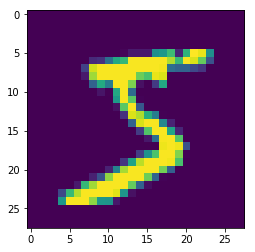

In [2]:
x = np.reshape(input_list, (-1, 28, 28, 1))
print(x.shape)
plt.imshow(x[0, :, :, 0])

In [3]:
y = np.reshape(target_list, (-1, 10))
print(y.shape)

y_pred = np.random.randn(y.shape[0], y.shape[1])
print(np.equal(y.argmax(axis=1), y_pred.argmax(axis=1)).sum() / len(y))


(200, 10)
0.095


(28, 28, 1)
(30, 30, 1)
[[-0.60901968  0.92152349 -1.22365251]
 [ 0.04182783  0.84079162  1.18940252]
 [ 0.53899681  2.11019796  0.20444162]]
(28, 28, 4)


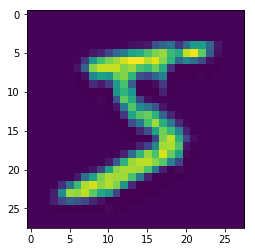

In [4]:
'''
convolution test for one image

'''
# take one image
xi = x[0, :, :, :]
print(xi.shape)

# padding
xp = np.zeros((xi.shape[0] + 2, xi.shape[1] + 2, 1)) + 0.01
xp[1:-1, 1:-1, :] = xi
print(xp.shape)
plt.imshow(xp[:, :, 0])

# convolution
f = np.random.randn(3,3,1,4)
print(f[:, :, 0, 0])

y = np.zeros((xi.shape[0], xi.shape[1], f.shape[3]))
print(y.shape)

#y[0, 0, :] = np.sum(xp[0:3, 0:3, :, None] * f, axis=(0,1,2))
#print(y)

for i in range(y.shape[0]):
    for j in range(y.shape[1]):
        xp_fraction = xp[i:i+3, j:j+3, :, None]   # dimension must be same to the filter's
        y[i, j, :] = np.sum(xp_fraction * f, axis=(0,1,2))

# activation
y = np.maximum(y, 0)
plt.imshow(y[:, :, 0])


(4, 28, 28, 1)
(4, 30, 30, 1)
[[-0.91048262  1.04033768 -2.15467828]
 [ 0.77758332 -0.21733334  0.21735788]
 [ 1.13160095 -1.07029154 -1.85043916]]
(4, 28, 28, 4)


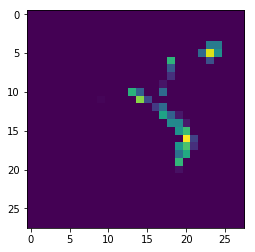

In [5]:
'''
convolution test for multiple images (e.g. minibatch)

'''
# take ten image
xi = x[0:4, :, :, :]
print(xi.shape)

# padding
xp = np.zeros((xi.shape[0], xi.shape[1] + 2, xi.shape[2] + 2, 1)) + 0.01
xp[:, 1:29, 1:29, :] = xi
print(xp.shape)
plt.imshow(xp[0, :, :, 0])

# convolution
f = np.random.randn(3,3,1,4)
print(f[:, :, 0, 0])

y = np.zeros((xi.shape[0], xi.shape[1], xi.shape[2], f.shape[3]))
print(y.shape)

for i in range(y.shape[1]):
    for j in range(y.shape[2]):
        xp_fraction = xp[:, i:i+3, j:j+3, :, None]
        y[:, i, j, :] = np.sum(xp_fraction * f, axis=(1,2,3))

# activation
y = np.maximum(y, 0)
plt.imshow(y[0, :, :, 0])

(4, 28, 28, 4)
(4, 14, 2, 14, 2, 4)
(4, 14, 14, 4)
(4, 7, 7, 4)


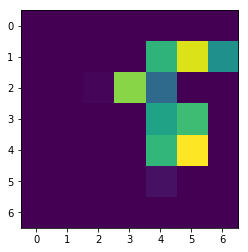

In [6]:
'''
max pooling test for multiple images

'''
print(y.shape)

y1 = y.reshape(y.shape[0], y.shape[1]//2, 2, y.shape[2]//2, 2, y.shape[3])
print(y1.shape)
y1 = y1.max(axis=(2, 4))
print(y1.shape)
plt.imshow(y1[0, :, :, 0])


y2 = y1.reshape(y1.shape[0], y1.shape[1]//2, 2, y1.shape[2]//2, 2, y1.shape[3])
y2 = y2.max(axis=(2, 4))
print(y2.shape)
plt.imshow(y2[0, :, :, 0])

In [7]:
'''
softmax test

'''
fl = y2.reshape(-1, 7*7*4)
print(fl.shape)

fm = fl.max(axis=1, keepdims=True)
print(fm.shape)

e_x = np.exp(fl - fm)
print(e_x.shape)
sf = e_x / e_x.sum(axis=1, keepdims=True)
print(sf.shape)

sf.sum(axis=1, keepdims=True)

(4, 196)
(4, 1)
(4, 196)
(4, 196)


array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

(4, 7, 7, 4)
(4, 14, 14, 4)
[[ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  0.  0.  0.  0.]
 [ 5.  5.  5.  5.  5.  0.  0.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]
 [ 5.  5.  5.  5.  5.  5.  5.  5.]]


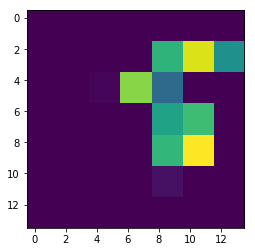

In [8]:
'''
max pooling backpropagation test

'''
print(y2.shape)
errmap = np.ones((4, 14, 14, 4)) * 5

temp = y2.repeat(2, axis=1).repeat(2, axis=2)
print(temp.shape)
plt.imshow(temp[0, :, :, 0])

mask = np.equal(y1, y2.repeat(2, axis=1).repeat(2, axis=2))
errmap = mask * errmap;
print(errmap[0, :8, :8, 0])

In [9]:
F = np.random.randn(3, 3, 32, 64)
Ft = F.transpose(1, 0, 3, 2)

print(F[:, :, 0, 1])
print(Ft[:, :, 1, 0])

[[-1.23169442 -0.69932613  2.00246155]
 [-0.12806699 -0.00882719 -0.48094108]
 [ 0.87135524  1.14900576  0.76125328]]
[[-1.23169442 -0.12806699  0.87135524]
 [-0.69932613 -0.00882719  1.14900576]
 [ 2.00246155 -0.48094108  0.76125328]]


In [10]:
z = np.random.randn(4, 14, 14, 16)
e = np.random.randn(4, 14, 14, 32)

fg = z[:, :, :, :, None] * e[:, :, :, None, :]
print(fg.shape)

fg = np.sum(fg, axis=(1,2))
print(fg.shape)

fg = np.mean(fg, axis=0)
print(fg.shape)

(4, 14, 14, 16, 32)
(4, 16, 32)
(16, 32)


In [11]:
import numpy as np
a = np.array([1, 2, 3])
b = np.array([[5, 5, 6], [7, 8, 9]])
c = np.array([a, b])

d = c.copy()

c.shape

(2,)

In [12]:
import numpy as np
a = np.array([[1, 2], [3, 4]])
b = a.sum(axis=0, keepdims=True)
print(b)
print(b.shape)


[[4 6]]
(1, 2)
